In [1]:
!pip install odeformer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 901.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 960.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 845.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:0

In [2]:
import odeformer
from odeformer.model import SymbolicTransformerRegressor

dstr = SymbolicTransformerRegressor(from_pretrained=True)
from odeformer.metrics import r2_score

Downloading...
From (original): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W
From (redirected): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W&confirm=t&uuid=054cb4d9-5142-496e-95e6-408d9eb6aee5
To: /content/odeformer.pt
100%|██████████| 465M/465M [00:06<00:00, 73.5MB/s]


Loaded pretrained model


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from odeformer.model.transformer import TransformerModel

# Enable output storage
TransformerModel.STORE_OUTPUTS = True

Discovered equation:
x_0' = -0.5033 * x_0

R² score: 0.9999326301145198


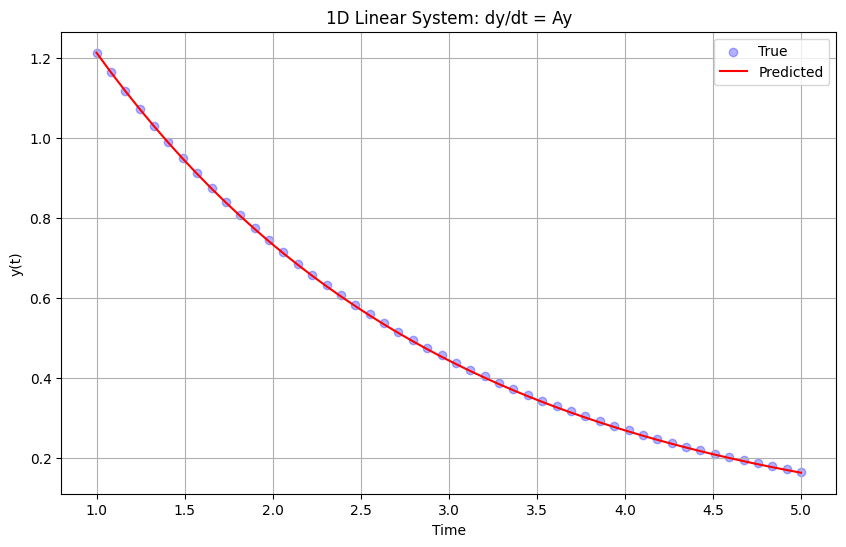

In [4]:
times = np.linspace(1, 5, 50)  # 50 points from 0 to 5

# Parameters
A = -0.5  # The coefficient in dy/dt = Ay
y0 = 2.0  # Initial condition

# Generate trajectory for dy/dt = Ay
# Solution is y(t) = y0*exp(At)
y = y0 * np.exp(A * times)
trajectory = y.reshape(-1, 1)  # Reshape for 1D system

# Fit the model
dstr.fit(times, trajectory)

# Get predictions
pred_traj = dstr.predict(times, trajectory[0])

# Print discovered equation
print("Discovered equation:")
dstr.print()

# Calculate R² score
score = r2_score(trajectory, pred_traj)
print(f"\nR² score: {score}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(times, trajectory, color='blue', label='True', alpha=0.3)
plt.plot(times, pred_traj, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Exponential Decay: dy/dt = Ay')
plt.legend()
plt.grid(True)
plt.show()

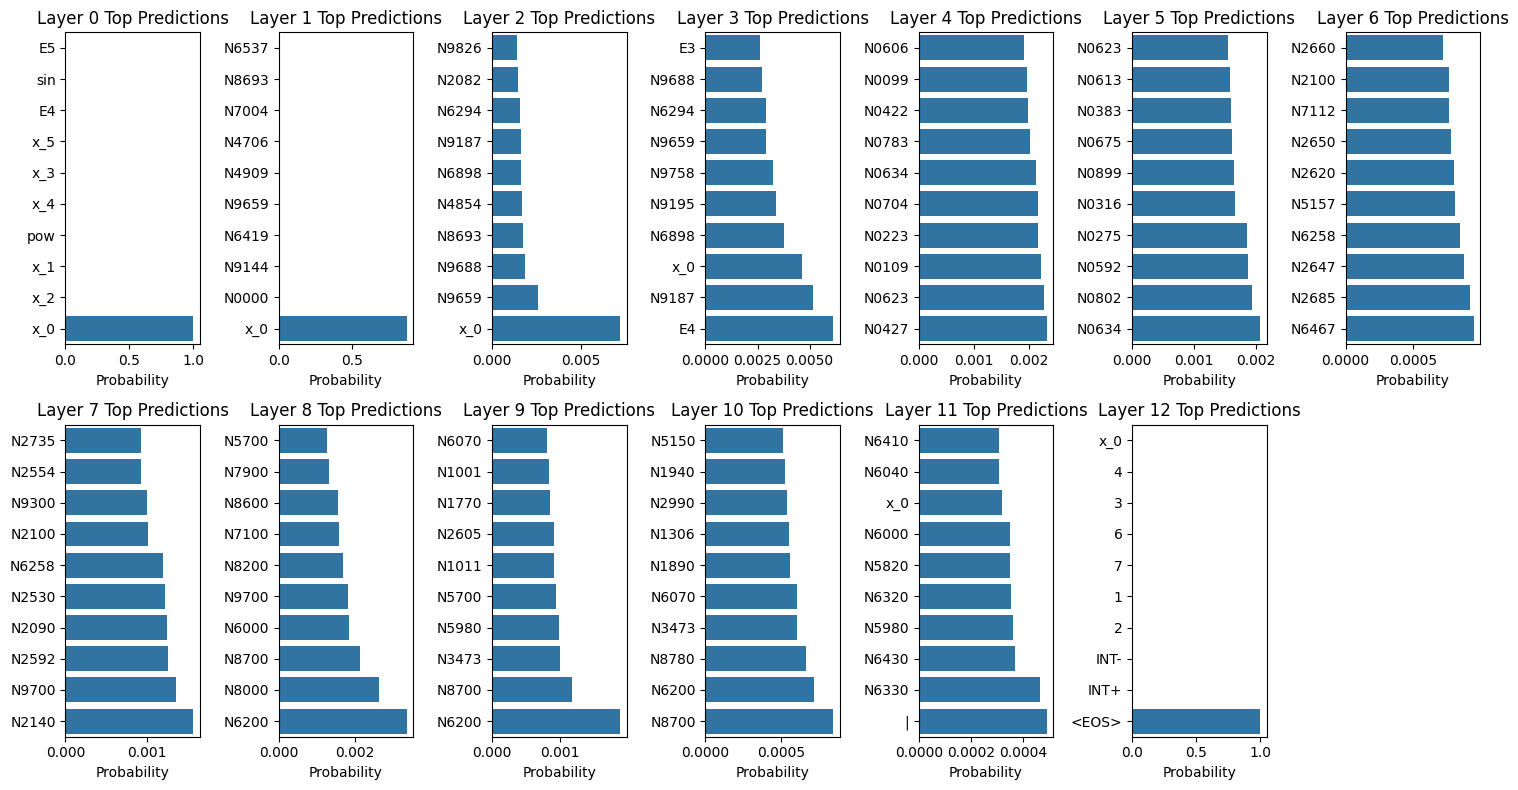

In [5]:
def token_distribution(model, times, trajectory):
    """
    Get token distributions from ODEFormer
    """
    # Enable output storage
    from odeformer.model.transformer import TransformerModel
    TransformerModel.STORE_OUTPUTS = True

    # Get the decoder from the model
    decoder = model.model.decoder

    # Store original outputs
    stored_outputs = []

    # Run a forward pass and collect activations
    with torch.no_grad():
        # Fit the model to collect activations
        model.fit(times, trajectory)

        # Get stored layer outputs
        layer_outputs = decoder.outputs

        # Process each layer's output
        for layer_idx, layer_output in enumerate(layer_outputs):
            # Project to logits
            logits = decoder.proj(layer_output)
            # Convert to probabilities
            probs = torch.softmax(logits, dim=-1)
            stored_outputs.append(probs)

    return stored_outputs, decoder.id2word

def visualize_token_distribution(outputs, id2word):
    plt.figure(figsize=(15, 8))

    # For each layer
    for layer_idx, layer_output in enumerate(outputs):
        plt.subplot(2, (len(outputs)+1)//2, layer_idx+1)

        # Get probabilities for first timestep
        probs = layer_output[0, 0].cpu().numpy()

        # Show top k tokens
        k = 10
        top_k_indices = np.argsort(probs)[-k:]
        top_k_words = [id2word[idx] for idx in top_k_indices]
        top_k_probs = probs[top_k_indices]

        sns.barplot(y=top_k_words, x=top_k_probs)
        plt.title(f'Layer {layer_idx} Top Predictions')
        plt.xlabel('Probability')

    plt.tight_layout()
    plt.show()

# Perform logit lens analysis
outputs, id2word = token_distribution(dstr, times, trajectory)

# Visualize the results
visualize_token_distribution(outputs, id2word)


In [6]:
from odeformer.model.transformer import TransformerModel
TransformerModel.STORE_OUTPUTS = True

# Get the decoder from the model
decoder = dstr.model.decoder

# Store original outputs
stored_outputs = []

# Run a forward pass and collect activations
with torch.no_grad():
# Fit the model to collect activations
  dstr.fit(times, trajectory)

# Get stored layer outputs
layer_outputs = decoder.outputs

# Process each layer's output
for layer_idx, layer_output in enumerate(layer_outputs):
# Project to logits
  logits = decoder.proj(layer_output)
  # Convert to probabilities
  probs = torch.softmax(logits, dim=-1)
  stored_outputs.append(probs)

print(stored_outputs)

[tensor([[[5.8233e-10, 7.9232e-10, 9.8878e-10,  ..., 1.1570e-09,
          2.0350e-10, 1.1599e-09]],

        [[5.8233e-10, 7.9232e-10, 9.8878e-10,  ..., 1.1570e-09,
          2.0350e-10, 1.1599e-09]],

        [[5.8233e-10, 7.9232e-10, 9.8878e-10,  ..., 1.1570e-09,
          2.0350e-10, 1.1599e-09]],

        ...,

        [[5.8233e-10, 7.9232e-10, 9.8878e-10,  ..., 1.1570e-09,
          2.0350e-10, 1.1599e-09]],

        [[5.8234e-10, 7.9232e-10, 9.8879e-10,  ..., 1.1570e-09,
          2.0350e-10, 1.1599e-09]],

        [[5.8234e-10, 7.9232e-10, 9.8879e-10,  ..., 1.1570e-09,
          2.0350e-10, 1.1599e-09]]], grad_fn=<SoftmaxBackward0>), tensor([[[1.6000e-09, 8.7711e-09, 1.0070e-09,  ..., 1.1922e-05,
          8.4751e-06, 1.6528e-09]],

        [[9.0541e-10, 5.1131e-09, 5.7127e-10,  ..., 1.8509e-05,
          1.3144e-05, 1.0065e-09]],

        [[9.0541e-10, 5.1131e-09, 5.7127e-10,  ..., 1.8509e-05,
          1.3144e-05, 1.0065e-09]],

        ...,

        [[9.0541e-10, 5.1131e-09,

In [7]:
print(layer_outputs)

[tensor([[[ 0.4487, -0.8885, -0.7349,  ..., -0.0256,  0.5598, -0.6980]],

        [[ 0.4487, -0.8885, -0.7349,  ..., -0.0256,  0.5598, -0.6980]],

        [[ 0.4487, -0.8885, -0.7349,  ..., -0.0256,  0.5598, -0.6980]],

        ...,

        [[ 0.4487, -0.8885, -0.7349,  ..., -0.0256,  0.5598, -0.6980]],

        [[ 0.4487, -0.8885, -0.7349,  ..., -0.0256,  0.5598, -0.6980]],

        [[ 0.4487, -0.8885, -0.7349,  ..., -0.0256,  0.5598, -0.6980]]]), tensor([[[ 0.5598, -0.1634, -0.7882,  ..., -0.3695,  0.7637,  0.3171]],

        [[ 0.5527, -0.1539, -0.7379,  ..., -0.3950,  0.8023,  0.2659]],

        [[ 0.5527, -0.1539, -0.7379,  ..., -0.3950,  0.8023,  0.2659]],

        ...,

        [[ 0.5527, -0.1539, -0.7379,  ..., -0.3950,  0.8023,  0.2659]],

        [[ 0.5430, -0.1650, -0.7638,  ..., -0.4015,  0.7928,  0.2895]],

        [[ 0.5527, -0.1539, -0.7379,  ..., -0.3950,  0.8023,  0.2659]]]), tensor([[[ 0.0355,  0.0049, -1.1838,  ...,  0.0337,  0.0387,  0.2854]],

        [[ 0.0378,  

In [8]:
np.shape(layer_outputs)

(13, 50, 1, 512)

In [9]:
type(stored_outputs)

list

In [10]:
list(map(type, stored_outputs))

[torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor]

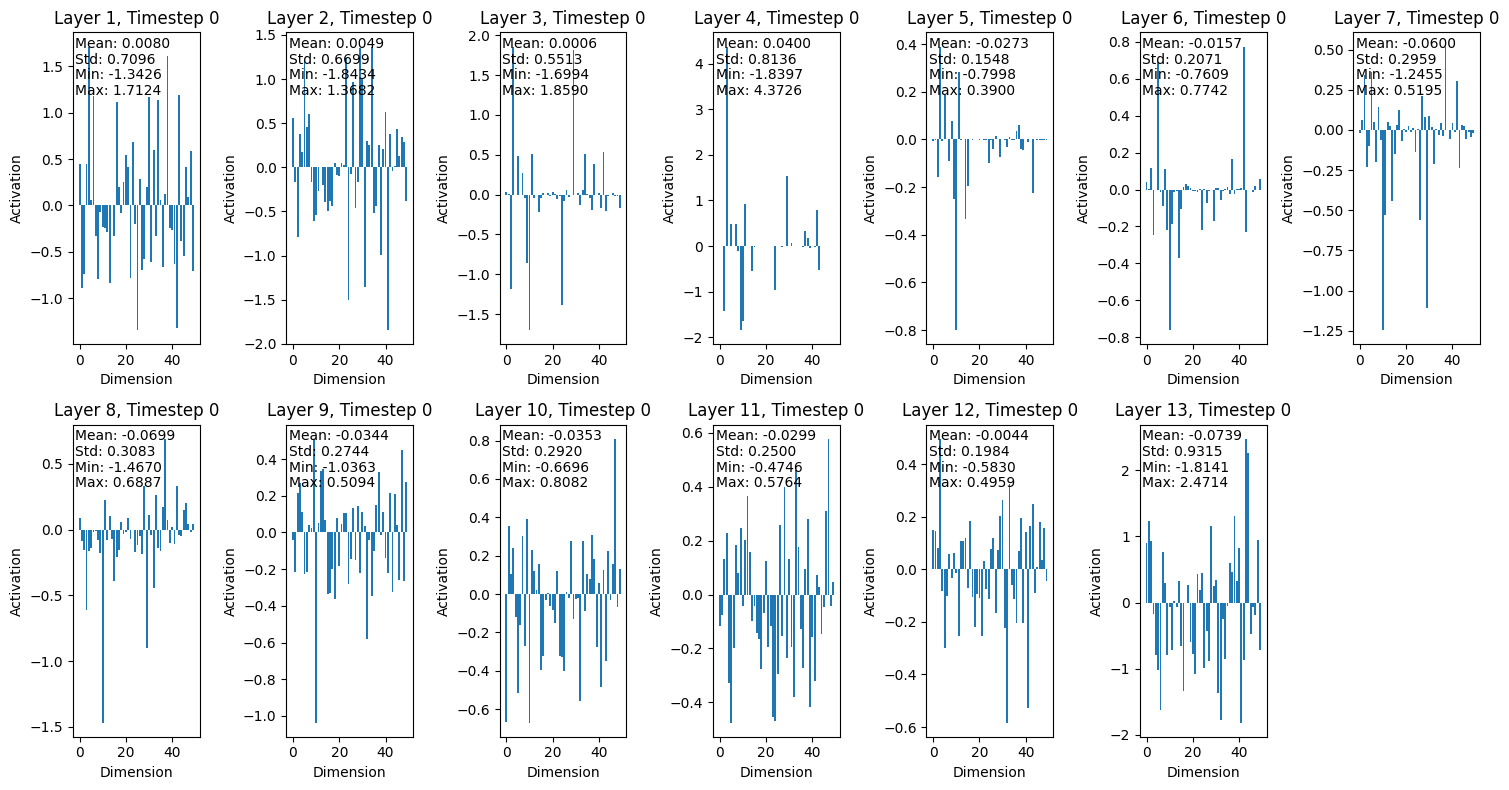

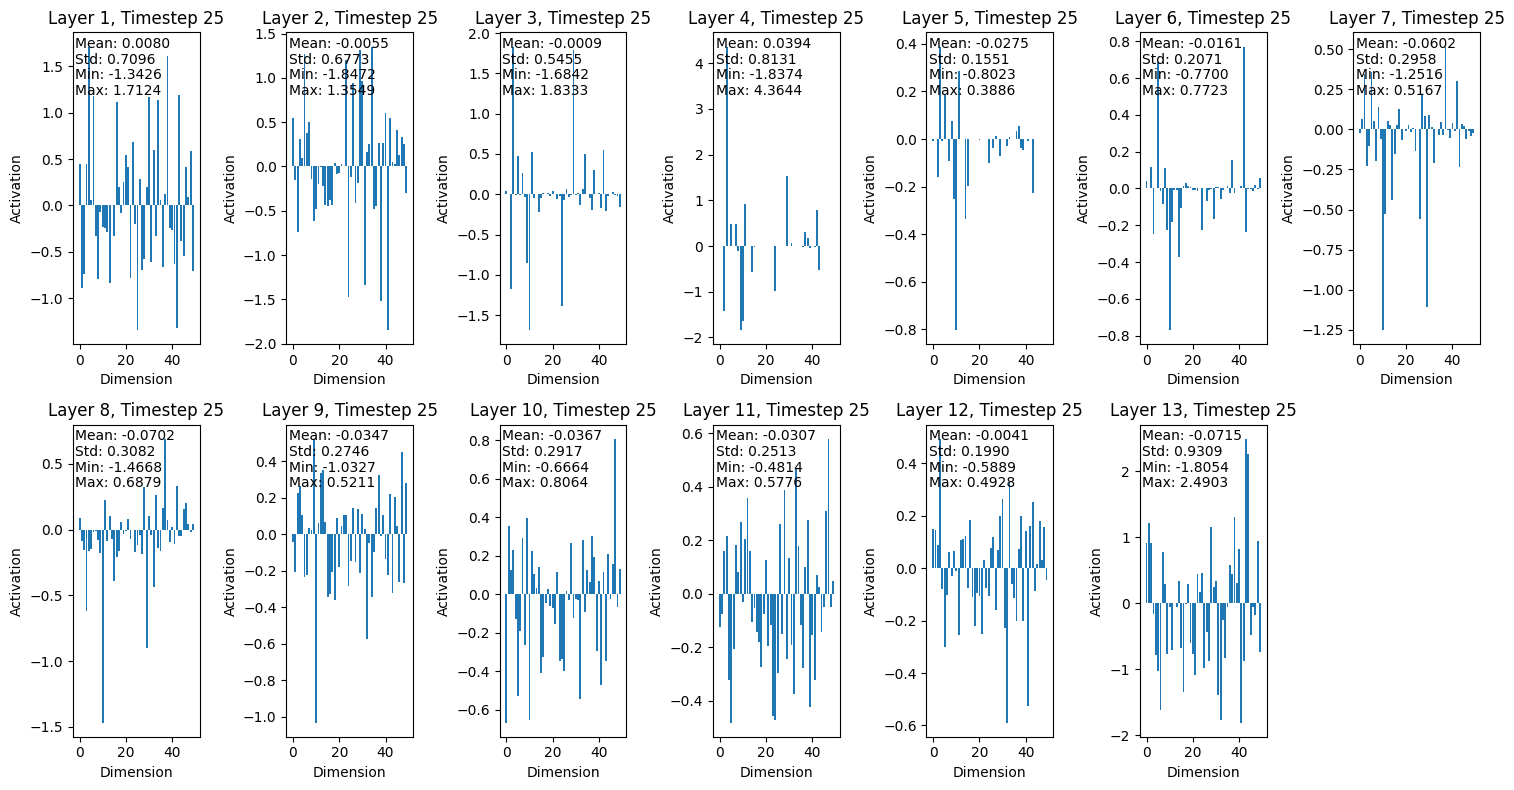

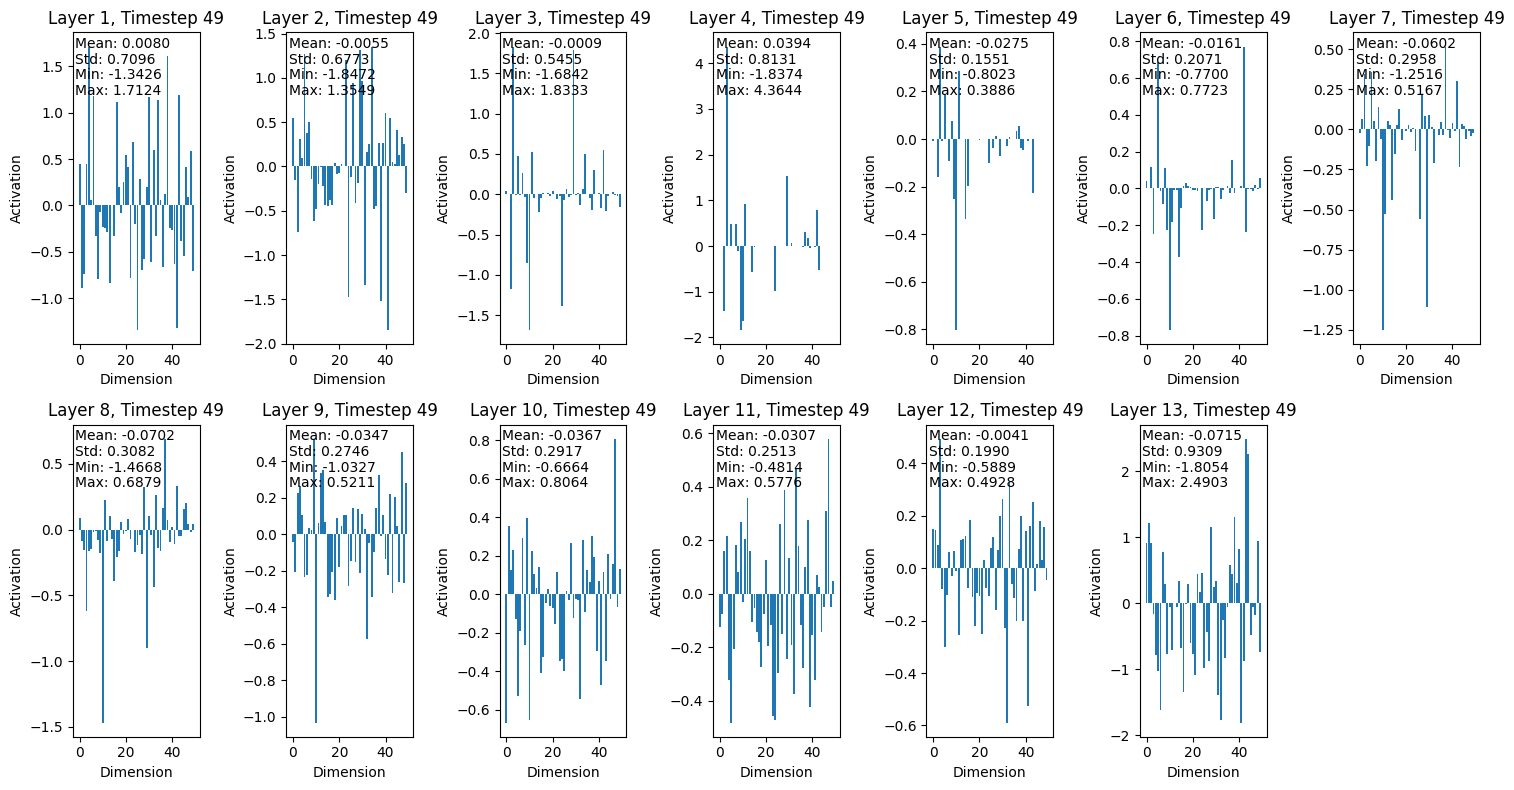

In [12]:
def visualize_layer_activations(layer_outputs, timestep=0, n_dims=50):
    """
    Visualize raw activations from transformer layers

    Parameters:
    - layer_outputs: List of tensor outputs from each layer
    - timestep: Which timestep to visualize (default: 0)
    - n_dims: Number of dimensions to plot (default: 50)
    """
    plt.figure(figsize=(15, 8))
    n_layers = len(layer_outputs)

    # For each layer
    for layer_idx, layer_tensor in enumerate(layer_outputs):
        plt.subplot(2, (n_layers+1)//2, layer_idx+1)

        # Check if tensor is valid and timestep exists
        if layer_tensor is not None and timestep < layer_tensor.shape[0]:
            # Extract hidden states for the specified timestep
            # Shape: (1, 512) -> Get the first n_dims
            hidden = layer_tensor[timestep, 0, :n_dims].detach().cpu().numpy()

            # Plot activations
            plt.bar(range(len(hidden)), hidden)
            plt.title(f'Layer {layer_idx+1}, Timestep {timestep}')
            plt.xlabel('Dimension')
            plt.ylabel('Activation')

            # Add some stats
            plt.text(0.02, 0.95, f"Mean: {hidden.mean():.4f}", transform=plt.gca().transAxes)
            plt.text(0.02, 0.90, f"Std: {hidden.std():.4f}", transform=plt.gca().transAxes)
            plt.text(0.02, 0.85, f"Min: {hidden.min():.4f}", transform=plt.gca().transAxes)
            plt.text(0.02, 0.80, f"Max: {hidden.max():.4f}", transform=plt.gca().transAxes)
        else:
            plt.text(0.5, 0.5, "Invalid tensor or timestep",
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_layer_activations(layer_outputs, timestep=0)  # First timestep
visualize_layer_activations(layer_outputs, timestep=25)  # Middle timestep
visualize_layer_activations(layer_outputs, timestep=49)  # Last timestep

In [13]:
def visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=0):
    """
    Visualize token probabilities across layers for a specific timestep

    Parameters:
    - layer_outputs: List of tensor outputs from each layer
    - decoder: The decoder model that contains the projection layer
    - id2word: Dictionary mapping token IDs to words
    - timestep: Which timestep to analyze (default: 0)
    """
    plt.figure(figsize=(15, 10))
    n_layers = len(layer_outputs)

    # Use no_grad to prevent gradient tracking
    with torch.no_grad():
        # For each layer
        for layer_idx, layer_tensor in enumerate(layer_outputs):
            plt.subplot(3, (n_layers+2)//3, layer_idx+1)

            try:
                # Check if tensor is valid and timestep exists
                if layer_tensor is not None and timestep < layer_tensor.shape[0]:
                    # Extract the hidden state for this timestep
                    # Ensure tensor is detached from computation graph
                    hidden = layer_tensor[timestep:timestep+1].clone().detach()

                    # Project to vocabulary space
                    logits = decoder.proj(hidden)

                    # Convert to probabilities
                    probs = torch.softmax(logits, dim=-1)[0, 0].cpu().numpy()

                    # Show top k tokens
                    k = min(10, len(probs))
                    top_k_indices = np.argsort(probs)[-k:][::-1]

                    # Get token names and probabilities
                    top_k_words = []
                    top_k_probs = []
                    for idx in top_k_indices:
                        if idx in id2word:
                            top_k_words.append(id2word[idx])
                            top_k_probs.append(probs[idx])

                    # Create bar plot
                    colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_k_probs)))
                    bars = plt.barh(top_k_words, top_k_probs, color=colors)

                    plt.title(f'Layer {layer_idx+1}, Timestep {timestep}')
                    plt.xlabel('Probability')
                    plt.ylabel('Token')
                    plt.xlim(0, 1)

                    # Add probability labels
                    for bar, prob in zip(bars, top_k_probs):
                        plt.text(min(prob + 0.03, 0.95), bar.get_y() + bar.get_height()/2,
                                f'{prob:.3f}', va='center')
                else:
                    plt.text(0.5, 0.5, "Invalid tensor or timestep",
                            horizontalalignment='center', verticalalignment='center',
                            transform=plt.gca().transAxes)
            except Exception as e:
                plt.text(0.5, 0.5, f"Error: {str(e)}",
                        horizontalalignment='center', verticalalignment='center',
                        transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

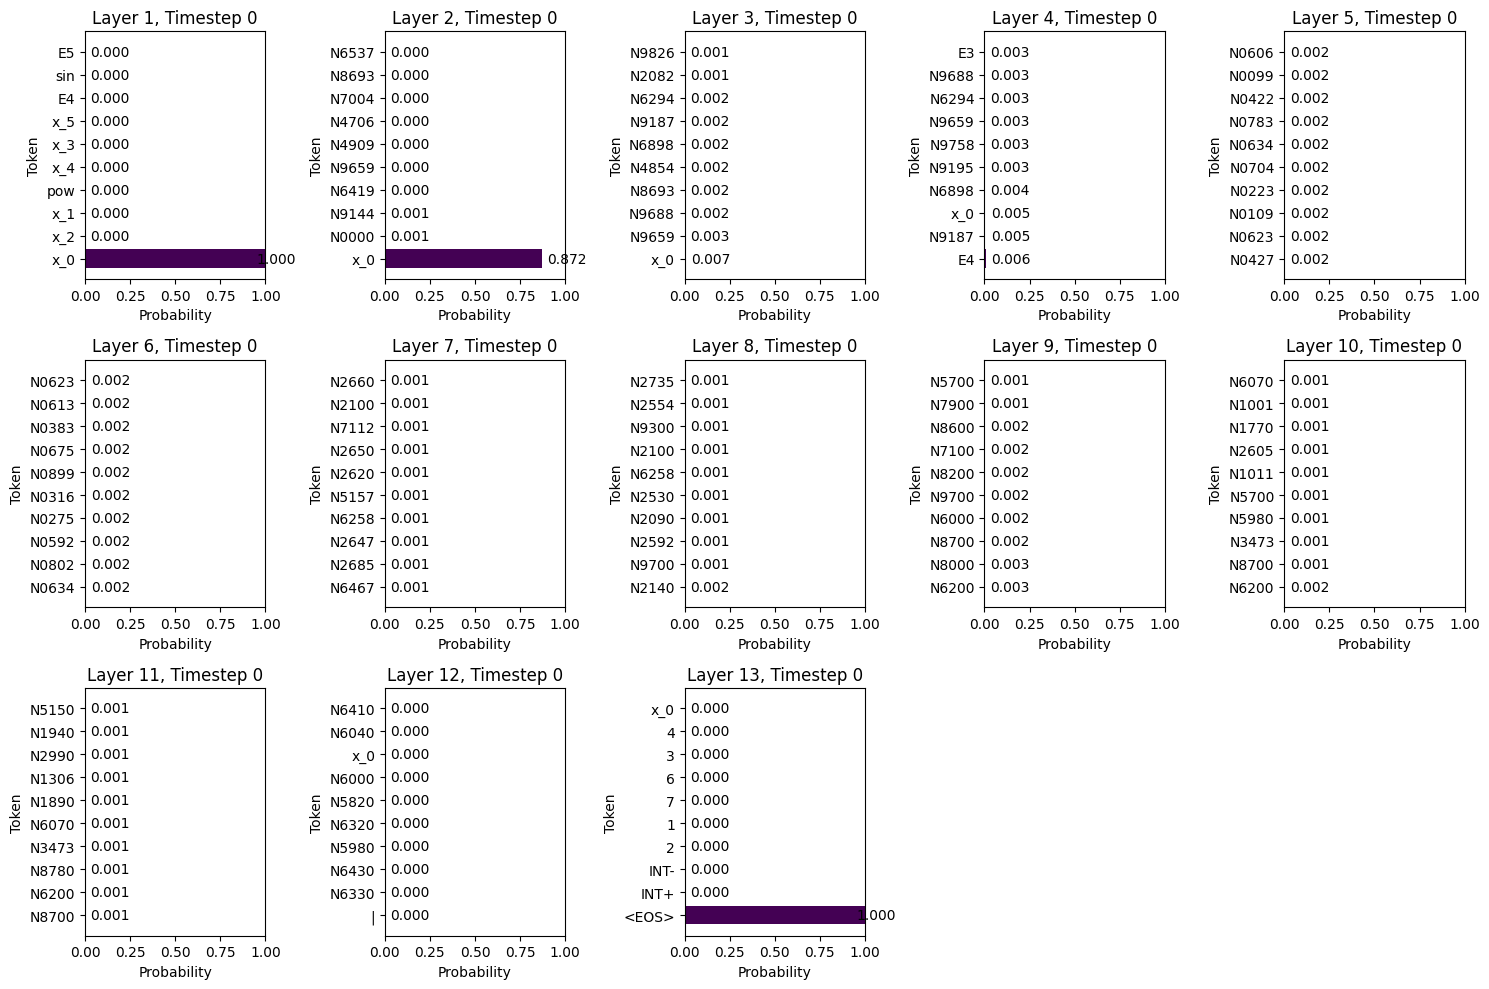

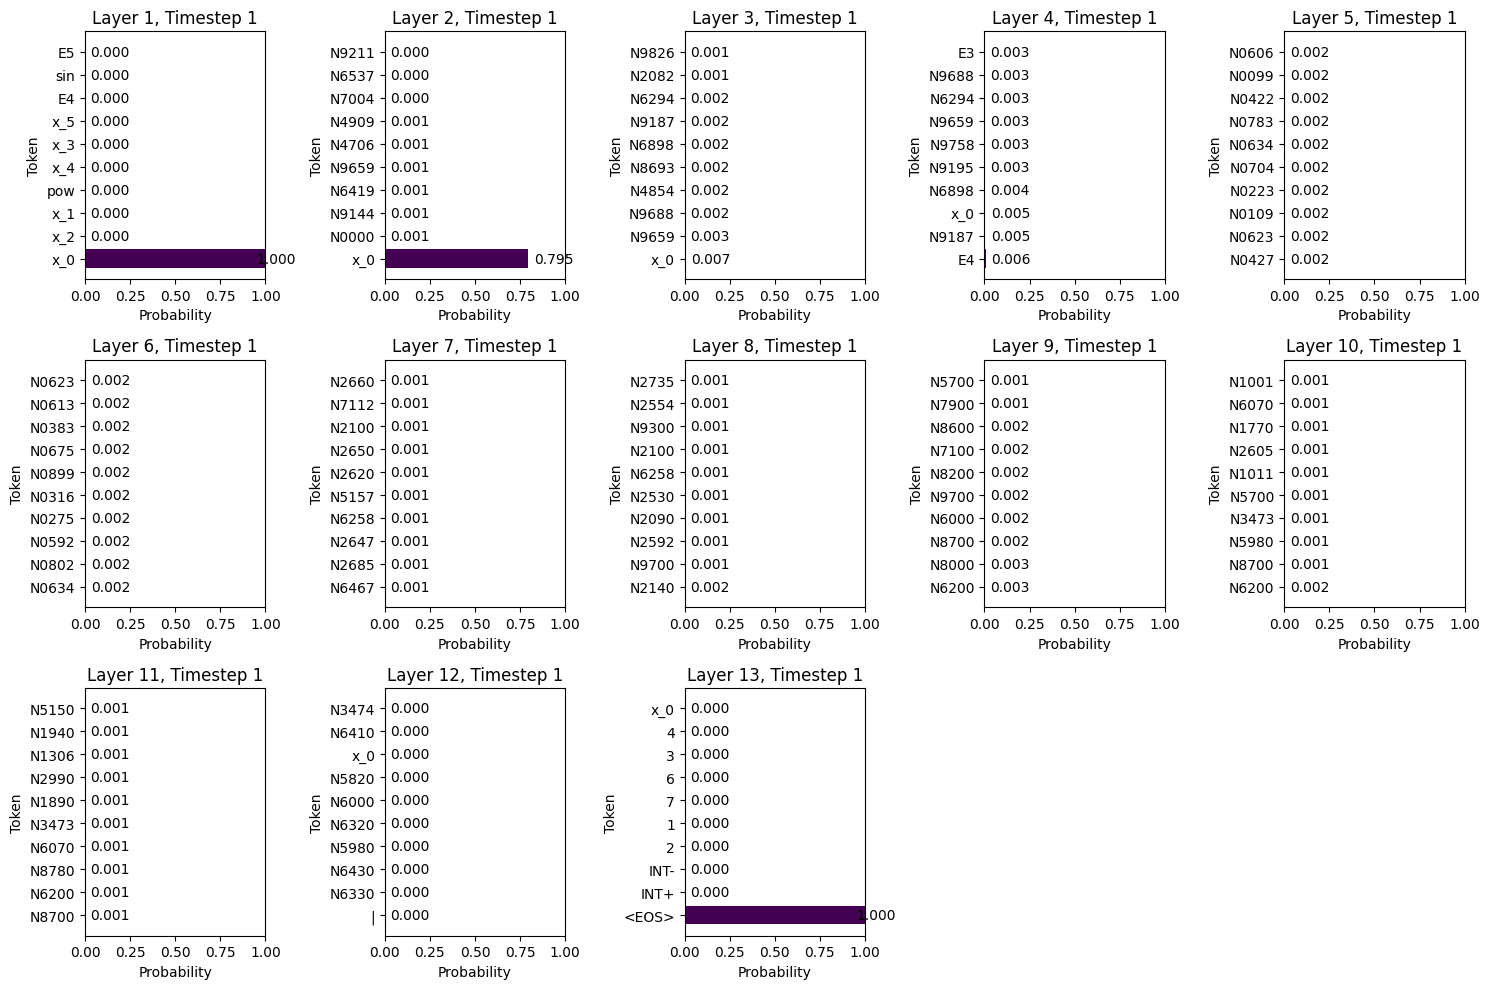

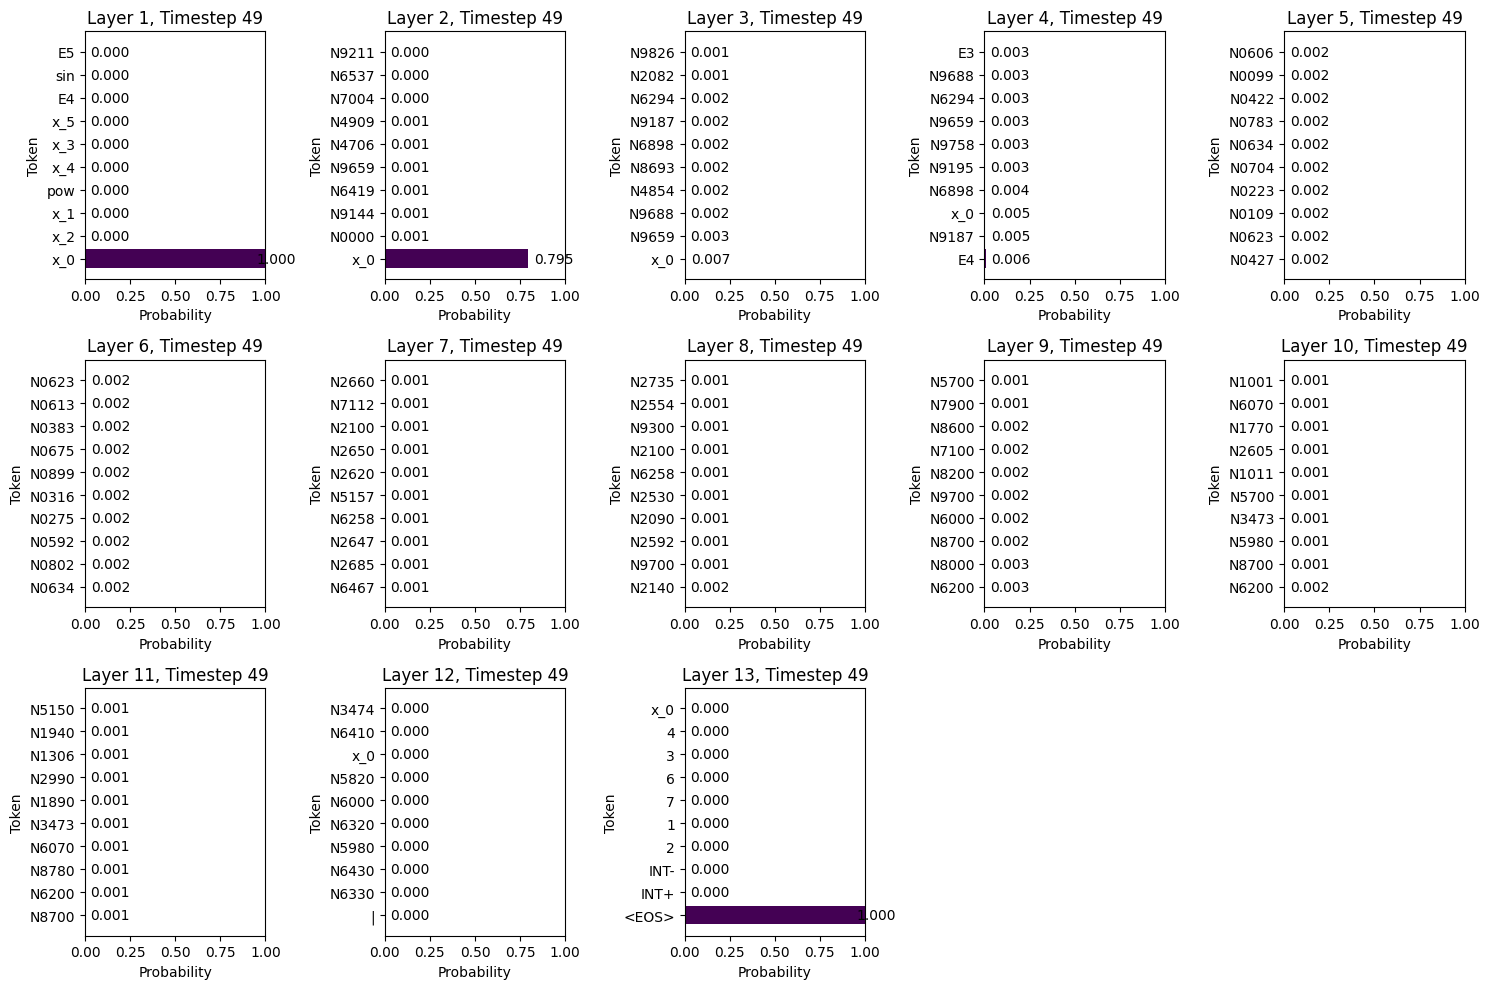

In [14]:
# First timestep
visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=0)

# You can try other timesteps
visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=1)
visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=49)

In [15]:
import numpy as np
import torch
import pandas as pd
from collections import defaultdict
from typing import Dict, List, Tuple

# Token categories
TOKEN_CATEGORIES = {
    'structure': {
        '<EOS>', '<X>', '</X>', '<Y>', '</Y>', '</POINTS>',
        '<INPUT_PAD>', '<OUTPUT_PAD>', '<MASK>', '<PAD>', '|',
        '(', ')', 'SPECIAL'
    },
    'operators': {
        'OOD_unary_op', 'OOD_binary_op', 'add', 'sub', 'mul', 'div',
        'pow', 'pow2', 'pow3'
    },
    'functions': {
        'abs', 'arccos', 'arcsin', 'arctan', 'cos', 'exp',
        'id', 'inv', 'log', 'sin', 'sqrt', 'tan'
    },
    'constants': {
        'OOD_constant', 'CONSTANT', 'e', 'euler_gamma', 'pi'
    },
    'e_notation': {f'E{i}' for i in range(-100, 101)},
    'numerics': {'FLOAT+', 'FLOAT-', 'INT+', 'INT-', 'NaN'}.union(
        {f'N{i:04d}' for i in range(10000)}
    ),
    'variables': {'t', 'rand'}.union({f'x_{i}' for i in range(10)})
}

def analyze_layer_tokens(outputs: List[torch.Tensor],
                        id2word: Dict[int, str],
                        threshold: float = 0.001) -> Dict[int, Dict[str, List[Tuple[str, float]]]]:
    """Analyze token distributions per layer for a single run."""
    layer_patterns = {}

    for layer_idx, layer_output in enumerate(outputs):
        # Get probabilities for first timestep
        probs = layer_output[0, 0].cpu().numpy()

        # Initialize categories for this layer
        categories = {cat: [] for cat in TOKEN_CATEGORIES.keys()}
        categories['unknown'] = []

        # Analyze tokens above threshold
        for token_idx, prob in enumerate(probs):
            if prob > threshold:
                token = id2word[token_idx]
                # Categorize token
                found = False
                for cat_name, cat_tokens in TOKEN_CATEGORIES.items():
                    if token in cat_tokens or (cat_name == 'numerics' and token.startswith('N')):
                        categories[cat_name].append((token, prob))
                        found = True
                        break
                if not found:
                    categories['unknown'].append((token, prob))

        layer_patterns[layer_idx] = categories

    return layer_patterns

def batch_analyze_layers(model, times, A_range, y0=2.0):
    """Run layer analysis across multiple exponential systems."""
    # Storage for layer patterns across all runs
    all_layer_patterns = []

    # Enable output storage
    from odeformer.model.transformer import TransformerModel
    TransformerModel.STORE_OUTPUTS = True

    # Process each system
    for i, A in enumerate(A_range):
        # Generate trajectory
        trajectory = y0 * np.exp(A * times).reshape(-1, 1)

        # Fit model and get outputs
        model.fit(times, trajectory)
        outputs, id2word = token_distribution(model, times, trajectory)

        # Analyze layer patterns
        layer_patterns = analyze_layer_tokens(outputs, id2word)
        all_layer_patterns.append(layer_patterns)

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(A_range)} systems")

    return all_layer_patterns

def compute_layer_statistics(all_patterns: List[Dict]) -> pd.DataFrame:
    """Compute statistics about layer behaviors across all runs."""
    n_layers = len(all_patterns[0])
    n_runs = len(all_patterns)

    # Initialize storage for statistics
    stats = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # Process all runs
    for run_patterns in all_patterns:
        for layer_idx in range(n_layers):
            layer_data = run_patterns[layer_idx]

            for category, tokens in layer_data.items():
                if tokens:  # If any tokens in this category
                    # Get probabilities
                    probs = [prob for _, prob in tokens]

                    # Update statistics
                    stats[layer_idx][category]['count'] += 1
                    stats[layer_idx][category]['avg_prob'] += np.mean(probs)
                    stats[layer_idx][category]['max_prob'] = max(
                        stats[layer_idx][category]['max_prob'],
                        max(probs)
                    )

    # Average the statistics across runs
    for layer_idx in range(n_layers):
        for category in stats[layer_idx]:
            if stats[layer_idx][category]['count'] > 0:
                stats[layer_idx][category]['usage_rate'] = stats[layer_idx][category]['count'] / n_runs
                stats[layer_idx][category]['avg_prob'] /= stats[layer_idx][category]['count']

    # Convert to DataFrame
    records = []
    for layer_idx in range(n_layers):
        for category in TOKEN_CATEGORIES.keys():
            if category in stats[layer_idx]:
                records.append({
                    'Layer': layer_idx,
                    'Category': category,
                    'Usage Rate': stats[layer_idx][category]['usage_rate'],
                    'Avg Probability': stats[layer_idx][category]['avg_prob'],
                    'Max Probability': stats[layer_idx][category]['max_prob']
                })

    df = pd.DataFrame(records)
    return df

def analyze_exp_layer_patterns(model, times, A_range):
    """Main function to analyze layer patterns across exponential systems."""
    # Run batch analysis
    all_patterns = batch_analyze_layers(model, times, A_range)

    # Compute statistics
    stats_df = compute_layer_statistics(all_patterns)

    # Print summary table
    print("\nLayer Pattern Statistics:")
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    print(stats_df)

    # Save detailed results
    return {
        'patterns': all_patterns,
        'statistics': stats_df
    }

# Example usage:
if __name__ == "__main__":
    # Time points
    times = np.linspace(0, 5, 50)

    # Generate range of coefficients
    A_range = np.linspace(-2.0, 2.0, 21)  # 21 points from -2 to 2

    # Run analysis
    results = analyze_exp_layer_patterns(dstr, times, A_range)

    # Access statistics
    stats_df = results['statistics']

    # Show layers that most frequently handle specific token types
    print("\nMost Active Layers per Token Category:")
    for category in TOKEN_CATEGORIES.keys():
        category_stats = stats_df[stats_df['Category'] == category].sort_values('Usage Rate', ascending=False)
        print(f"\n{category}:")
        # Display without index
        print(category_stats.head(3)[['Layer', 'Usage Rate', 'Avg Probability']].to_string(index=False))

Processed 10/21 systems
Processed 20/21 systems

Layer Pattern Statistics:
    Layer    Category  Usage Rate  Avg Probability  Max Probability
0       0   variables       0.714            1.000            1.000
1       1    numerics       0.524            0.001            0.002
2       1   variables       0.714            0.803            0.879
3       2    numerics       0.810            0.001            0.003
4       2   variables       0.714            0.007            0.007
5       3  e_notation       0.714            0.003            0.006
6       3    numerics       0.810            0.002            0.010
7       3   variables       0.714            0.003            0.005
8       4   structure       0.810            0.002            0.013
9       4   operators       0.095            0.001            0.001
10      4   functions       0.714            0.001            0.001
11      4   constants       0.810            0.001            0.002
12      4  e_notation       0.810        

Discovered equation:
x_0' = -1.0098 * (x_0)**2

R² score: 0.9999694478291276


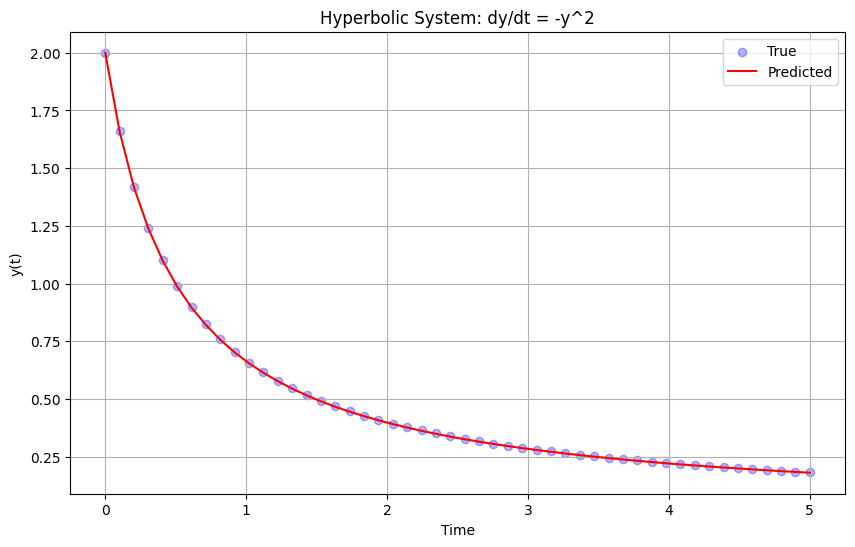

In [16]:
times = np.linspace(0, 5, 50)  # 50 points from 0 to 5

# Parameters
y0 = 2.0  # Initial condition

y = 1.0 / (times + 1.0/y0)
trajectory = y.reshape(-1, 1)  # Reshape for 1D system

# Fit the model
dstr.fit(times, trajectory)

# Get predictions
pred_traj = dstr.predict(times, trajectory[0])

# Print discovered equation
print("Discovered equation:")
dstr.print()

# Calculate R² score
score = r2_score(trajectory, pred_traj)
print(f"\nR² score: {score}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(times, trajectory, color='blue', label='True', alpha=0.3)
plt.plot(times, pred_traj, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Hyperbolic System: dy/dt = -y^2')
plt.legend()
plt.grid(True)
plt.show()

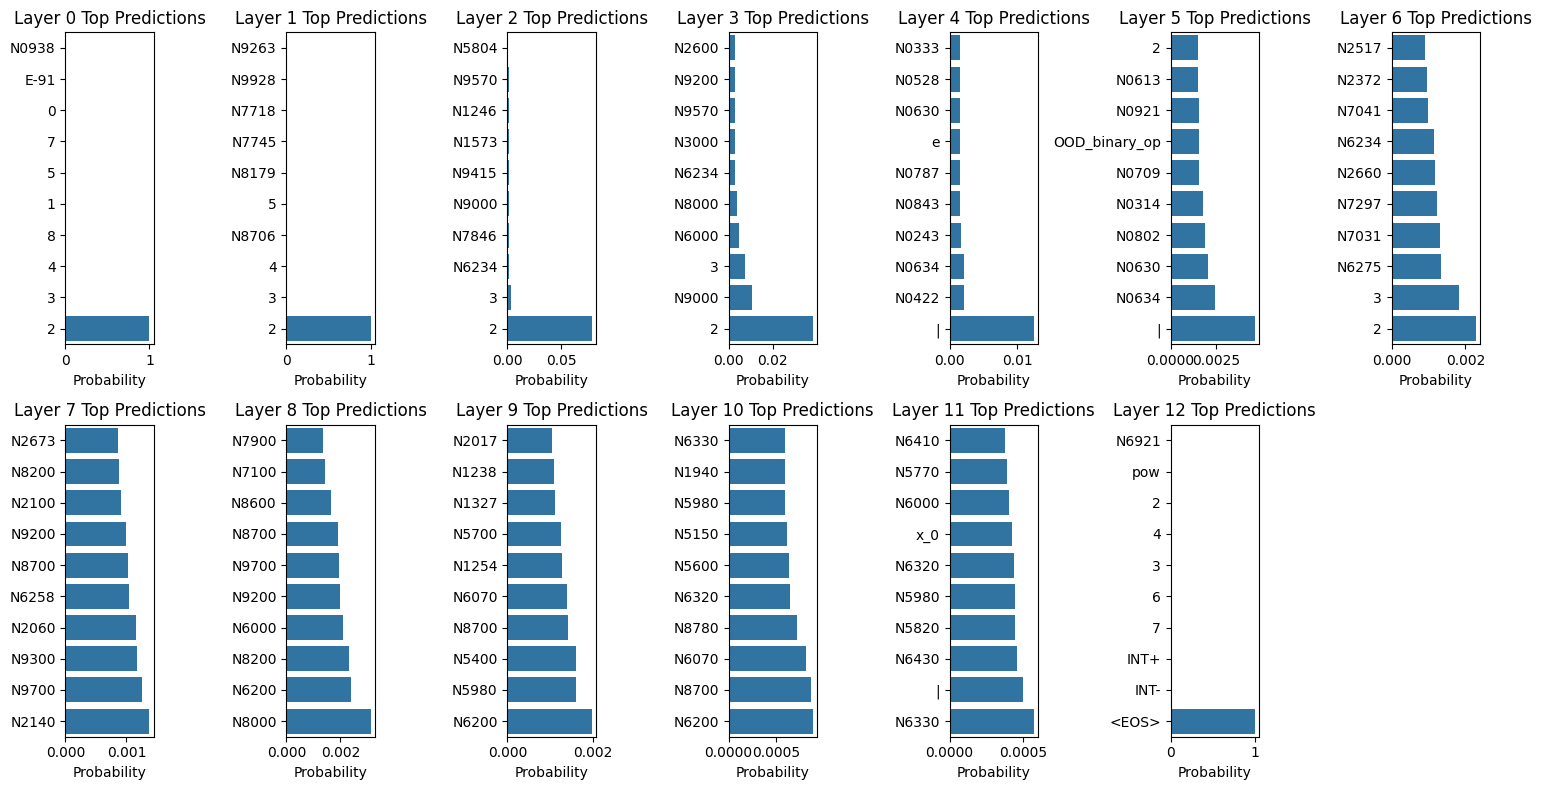

In [17]:
# Perform logit lens analysis
outputs, id2word = token_distribution(dstr, times, trajectory)

# Visualize the results
visualize_token_distribution(outputs, id2word)


In [18]:
# Get the decoder from the model
decoder = dstr.model.decoder

# Store original outputs
stored_outputs = []

# Run a forward pass and collect activations
with torch.no_grad():
# Fit the model to collect activations
  dstr.fit(times, trajectory)

# Get stored layer outputs
layer_outputs = decoder.outputs

# Process each layer's output
for layer_idx, layer_output in enumerate(layer_outputs):
# Project to logits
  logits = decoder.proj(layer_output)
  # Convert to probabilities
  probs = torch.softmax(logits, dim=-1)
  stored_outputs.append(probs)

print(stored_outputs)

[tensor([[[1.0098e-11, 8.7337e-12, 9.8861e-12,  ..., 1.0740e-13,
          8.1955e-14, 9.3898e-12]],

        [[1.0098e-11, 8.7337e-12, 9.8861e-12,  ..., 1.0740e-13,
          8.1955e-14, 9.3898e-12]],

        [[1.0098e-11, 8.7337e-12, 9.8861e-12,  ..., 1.0740e-13,
          8.1955e-14, 9.3898e-12]],

        ...,

        [[1.0098e-11, 8.7337e-12, 9.8861e-12,  ..., 1.0740e-13,
          8.1955e-14, 9.3898e-12]],

        [[1.0098e-11, 8.7338e-12, 9.8863e-12,  ..., 1.0740e-13,
          8.1956e-14, 9.3899e-12]],

        [[1.0098e-11, 8.7338e-12, 9.8863e-12,  ..., 1.0740e-13,
          8.1956e-14, 9.3899e-12]]], grad_fn=<SoftmaxBackward0>), tensor([[[2.3731e-15, 4.8782e-15, 1.8437e-15,  ..., 3.4708e-08,
          5.3560e-09, 3.2663e-15]],

        [[2.3731e-15, 4.8782e-15, 1.8437e-15,  ..., 3.4708e-08,
          5.3560e-09, 3.2663e-15]],

        [[1.8616e-15, 3.7349e-15, 1.4831e-15,  ..., 2.9575e-08,
          4.7427e-09, 2.5814e-15]],

        ...,

        [[1.8616e-15, 3.7349e-15,

In [19]:
print(layer_outputs)

[tensor([[[-1.4677,  0.0896,  0.2873,  ...,  0.9739, -0.4518, -0.6247]],

        [[-1.4677,  0.0896,  0.2873,  ...,  0.9739, -0.4518, -0.6247]],

        [[-1.4677,  0.0896,  0.2873,  ...,  0.9739, -0.4518, -0.6247]],

        ...,

        [[-1.4677,  0.0896,  0.2873,  ...,  0.9739, -0.4518, -0.6247]],

        [[-1.4677,  0.0896,  0.2873,  ...,  0.9739, -0.4518, -0.6247]],

        [[-1.4677,  0.0896,  0.2873,  ...,  0.9739, -0.4518, -0.6247]]]), tensor([[[-0.2471, -0.0648,  0.3388,  ...,  0.6696,  0.1298,  0.3769]],

        [[-0.2471, -0.0648,  0.3388,  ...,  0.6696,  0.1298,  0.3769]],

        [[-0.2469, -0.0720,  0.3511,  ...,  0.6935,  0.1054,  0.3578]],

        ...,

        [[-0.2469, -0.0720,  0.3511,  ...,  0.6935,  0.1054,  0.3578]],

        [[-0.2094, -0.0887,  0.3437,  ...,  0.6683,  0.0633,  0.3817]],

        [[-0.2288, -0.0593,  0.2580,  ...,  0.6915,  0.1406,  0.4214]]]), tensor([[[-0.1941,  0.0394,  0.5766,  ...,  0.1293, -0.1957,  0.3627]],

        [[-0.1941,  

In [20]:
np.shape(layer_outputs)

(13, 50, 1, 512)

In [21]:
type(stored_outputs)

list

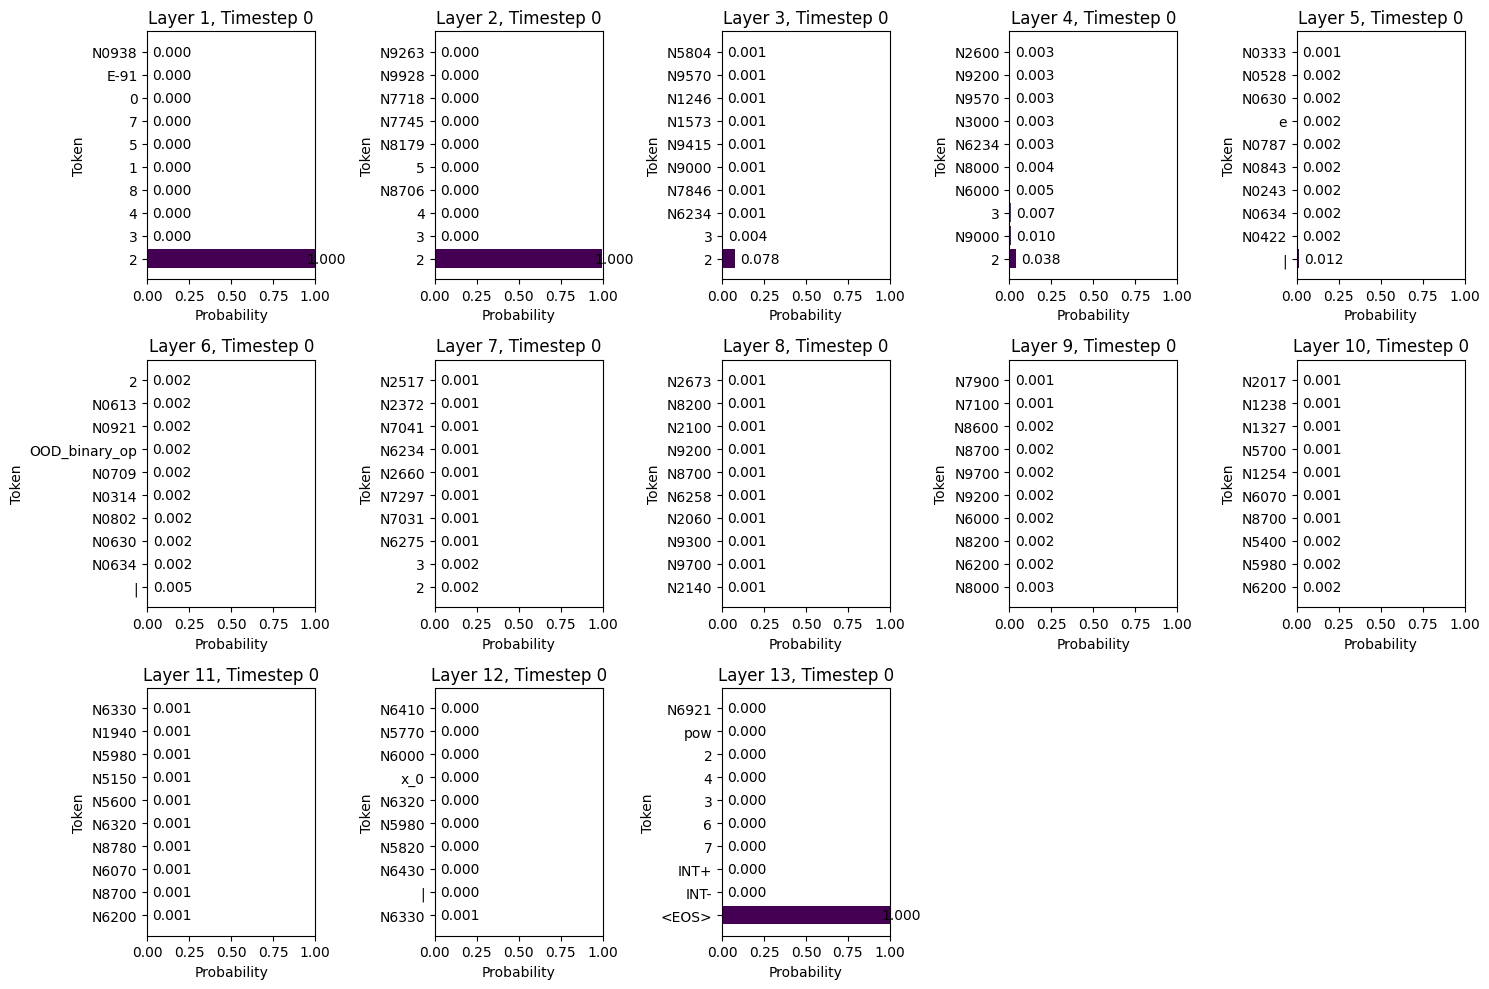

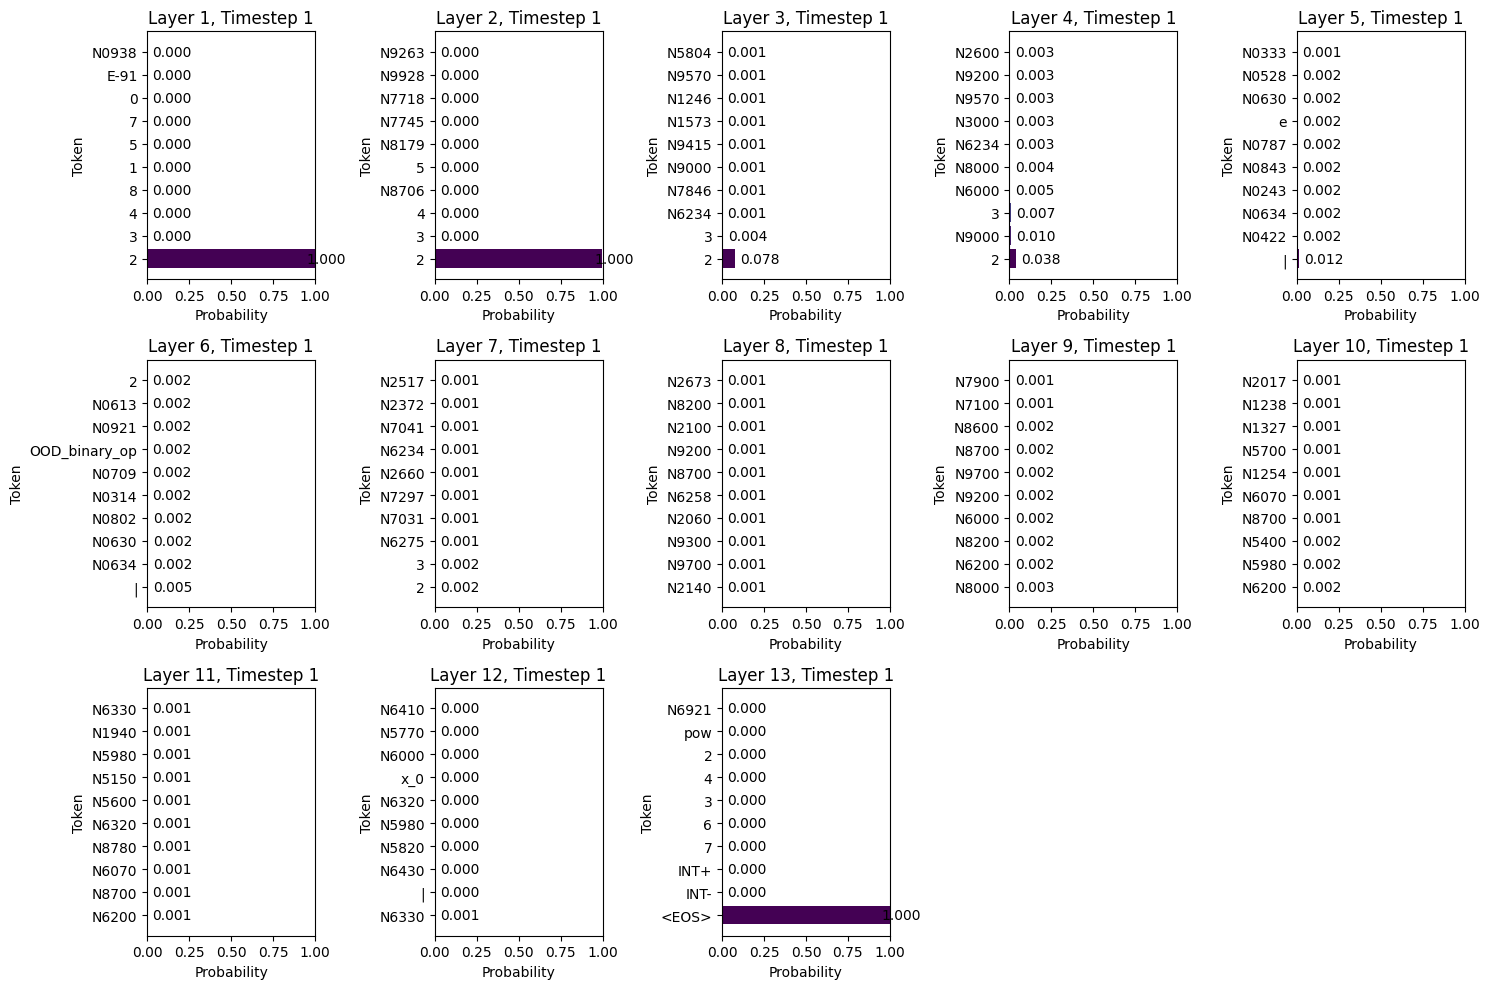

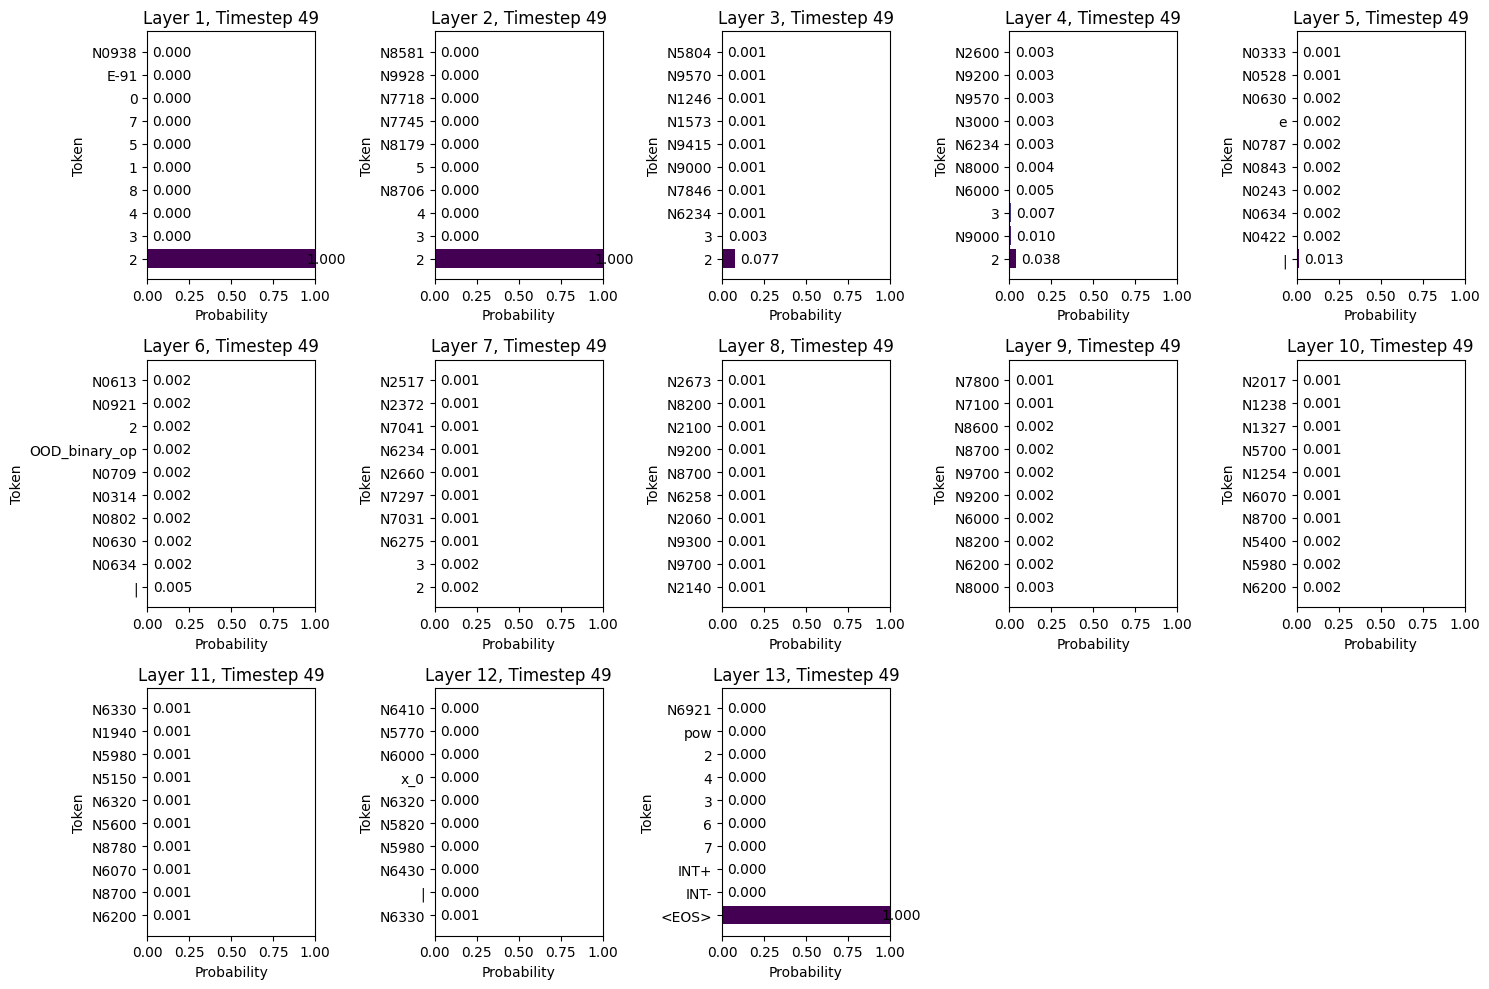

In [22]:
# First timestep
visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=0)

# You can try other timesteps
visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=1)
visualize_token_probabilities(layer_outputs, decoder, id2word, timestep=49)